# Calculating Hotel Occupancy

---

> Hotel occupancy is a critical factor during the booking process and can provide additional insight into the likelihood of cancellations and/or forecasting future ADR.
> 
> However, *there's no clear indication of the total number of guest rooms for either hotel.*
>
> 
> I will determine the maximum number of rooms occupied for each date for each hotel, which can be used as a placeholder max occupancy number.

---

# Import Packages and Read Data

In [1]:
## Used to upload 
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np

import datetime as dt

## Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## Custom-made Functions
# from bmc_functions import eda

In [3]:
## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
%matplotlib inline

## Read-In Data

---

***NOTE:** Load data for one hotel at a time - need to calculate occupancies for each hotel separately.*

---

In [4]:
# data_path_H1 = './data/H1.csv'

# data1 = pd.read_csv(data_path_H1)
# data1['HotelNumber'] = 1
# data1.head()

In [5]:
# occupancy_cols = ['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights']
data_path = './data/H1.parquet'

In [6]:
df_data = pd.read_parquet(data_path)#, columns = occupancy_cols)
df_data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03


In [7]:
# data_path_H2 = './data/H2.csv'

# data2 = pd.read_csv(data_path_H2)
# data2['HotelNumber'] = 2
# # data2.head()

In [8]:
# ## Combine both datasets
# df_data = pd.concat([data1, data2], axis = 0).reset_index(drop=True)
# df_data.head()

In [9]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13  MarketSegment   

# Begin Time Series Resampling

## Calculate Arrival Date

In [10]:
## Convert Arrival columns to strings

arrival_date_cols = ['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth']

arrival_date_cols_str = df_data[arrival_date_cols].astype(str)
arrival_date_cols_str.head()

,ArrivalDateYear,ArrivalDateMonth,ArrivalDateDayOfMonth
0,2015,July,1
1,2015,July,1
2,2015,July,1
3,2015,July,1
4,2015,July,1


In [11]:
## Create new column of strings formatted as YYYY-MM-DD, then convert to datetime

arrival_date_full_str = arrival_date_cols_str['ArrivalDateYear'] + '-' + \
                        arrival_date_cols_str['ArrivalDateMonth'] + '-' + \
                        arrival_date_cols_str['ArrivalDateDayOfMonth']

arrival_date_dt = pd.to_datetime(arrival_date_full_str, yearfirst = True)
arrival_date_dt.name = 'Arrival_Date'
arrival_date_dt

0       2015-07-01
1       2015-07-01
2       2015-07-01
3       2015-07-01
4       2015-07-01
           ...    
40055   2017-08-31
40056   2017-08-30
40057   2017-08-29
40058   2017-08-31
40059   2017-08-31
Name: Arrival_Date, Length: 40060, dtype: datetime64[ns]

In [12]:
## Concatenate new column
df_data = pd.concat([df_data, arrival_date_dt], axis = 1)
df_data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01


In [13]:
df_data.columns.to_list()

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'ReservationStatusDate',
 'Arrival_Date']

In [14]:
df_data = df_data.drop(columns=[ 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth'])
df_data

,IsCanceled,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date
0,0,342,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,0,737,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,0,7,27,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,0,13,27,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,0,14,27,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,35,2,8,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10,2017-08-31
40056,0,169,35,2,9,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10,2017-08-30
40057,0,204,35,4,10,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12,2017-08-29
40058,0,211,35,4,10,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14,2017-08-31


## Calculate Departure Date

In [15]:
## Testing creation of timedelta series to add additional nights to arrival date
pd.to_timedelta(df_data.loc[:, 'StaysInWeekendNights'], unit = 'D')

0       0 days
1       0 days
2       0 days
3       0 days
4       0 days
         ...  
40055   2 days
40056   2 days
40057   4 days
40058   4 days
40059   4 days
Name: StaysInWeekendNights, Length: 40060, dtype: timedelta64[ns]

In [16]:
## Create timedelta series based on number of weekday/end nights.
timedelta_wknd = pd.to_timedelta(df_data.loc[:, 'StaysInWeekendNights'], unit = 'D')
timedelta_wk = pd.to_timedelta(df_data.loc[:, 'StaysInWeekNights'], unit = 'D')

In [17]:
## Calculate the departure date by adding the timedeltas to the arrival date
departure_date = df_data.loc[:, 'Arrival_Date'] + timedelta_wk + timedelta_wknd
departure_date.name = 'Departure_Date'
departure_date

0       2015-07-01
1       2015-07-01
2       2015-07-02
3       2015-07-02
4       2015-07-03
           ...    
40055   2017-09-10
40056   2017-09-10
40057   2017-09-12
40058   2017-09-14
40059   2017-09-14
Name: Departure_Date, Length: 40060, dtype: datetime64[ns]

In [18]:
## Concatenate with original dataframe
df_data = pd.concat([df_data, departure_date], axis = 1)
df_data.head()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date
0,0,342,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01
1,0,737,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01
2,0,7,27,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02
3,0,13,27,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02
4,0,14,27,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2015-07-03


In [19]:
df_data = df_data.drop(columns=['StaysInWeekendNights', 'StaysInWeekNights'])
df_data

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date
0,0,342,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01
1,0,737,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01
2,0,7,27,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02
3,0,13,27,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02
4,0,14,27,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,35,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10,2017-08-31,2017-09-10
40056,0,169,35,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10,2017-08-30,2017-09-10
40057,0,204,35,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12,2017-08-29,2017-09-12
40058,0,211,35,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14,2017-08-31,2017-09-14


## Calculate Daily Occupancies

In [20]:
min_date = df_data['Arrival_Date'].min()
max_date = df_data['Departure_Date'].max()

print(f'The earliest date is: {min_date}.\nThe latest date is: {max_date}.')

The earliest date is: 2015-07-01 00:00:00.
The latest date is: 2017-09-14 00:00:00.


### ChatGPT-Generated Code

#### Walkthrough of Code Below

Certainly! Let's break down the corrected code into its key steps, explaining each part and its purpose in calculating the number of active hotel reservations for each date:

**1. Sample Data Creation**

```python
df_data = pd.DataFrame({
    'Arrival_Date': ['2023-01-01', '2023-01-02', '2023-01-05', '2023-01-05'],
    'Departure_Date': ['2023-01-04', '2023-01-03', '2023-01-06', '2023-01-07']
})
```
- This step initializes `df_data`, a pandas DataFrame with two columns: `Arrival_Date` and `Departure_Date`. Each row represents a reservation with its arrival and departure dates.

**2. Convert Dates to Datetime Format**

```python
df_data['Arrival_Date'] = pd.to_datetime(df_data['Arrival_Date'])
df_data['Departure_Date'] = pd.to_datetime(df_data['Departure_Date'])
```
- Converts the date columns from strings (or any other format they might be in) to pandas datetime objects, allowing for date arithmetic and other time-series operations.

**3. Generate Counts for Arrivals and Departures**

```python
arrivals = df_data['Arrival_Date'].value_counts().rename('count')
departures = df_data['Departure_Date'].value_counts().rename('count')
```
- Counts how many reservations start (`arrivals`) and end (`departures`) on each date. The `value_counts()` method tallies occurrences of each date, and `rename('count')` changes the Series name to `'count'`, which aids in clarity for later operations.

**4. Combine Arrival and Departure Counts**

```python
df_counts = pd.concat([arrivals, -departures]).sort_index().reset_index()
df_counts.columns = ['Date', 'Count']
```
- Combines the arrivals and departures into a single DataFrame, `df_counts`, with arrivals contributing positively to the count and departures negatively (indicating the end of a reservation). The data is then sorted by date.

**5. Aggregate Counts on the Same Date**

```python
df_counts = df_counts.groupby('Date').sum()
```
- Since the combination of arrivals and departures could result in multiple entries for the same date, this step aggregates (sums) all counts for each date. This ensures each date is unique, addressing the initial issue of duplicate labels.

**6. Generate a Complete Date Range and Reindex**

```python
date_range = pd.date_range(start=df_counts.index.min(), end=df_counts.index.max())
df_counts = df_counts.reindex(date_range, fill_value=0)
```
- Creates a continuous range of dates covering the entire period from the earliest to the latest date in `df_counts`. It then reindexes `df_counts` to include every date in this range, filling any dates without data with `0`, ensuring there's a record for every single day in the period.

**7. Calculate Cumulative Sum for Active Reservations**

```python
df_counts['Active_Reservations'] = df_counts['Count'].cumsum()
```
- Computes the cumulative sum of the daily net reservation counts (`Count`). This step effectively calculates the total number of active reservations for each date by adding up the arrivals and subtracting the departures as they occur over time.

**Conclusion**

- The final output, `df_counts['Active_Reservations']`, shows the total number of active reservations for each date in the range. This method is efficient and avoids the problem of duplicate labels by ensuring that each date is unique before the reindexing step, leveraging pandas' capabilities for handling time series data.

### Code

In [21]:
# Generate counts for arrivals and departures on their respective dates
arrivals = df_data['Arrival_Date'].value_counts().rename('count')
departures = df_data['Departure_Date'].value_counts().rename('count')
arrivals.head(), departures.head()

(Arrival_Date
 2015-12-05    222
 2016-02-12    175
 2016-03-24    170
 2016-02-26    154
 2015-09-17    152
 Name: count, dtype: int64,
 Departure_Date
 2016-02-29    211
 2016-02-14    209
 2015-12-08    205
 2015-11-15    169
 2015-10-12    151
 Name: count, dtype: int64)

In [22]:
# Create a DataFrame from arrivals and departures, marking departures as negative
df_counts = pd.concat([arrivals, -departures]).sort_index().reset_index()
df_counts.columns = ['Date', 'Count']
df_counts

,Date,Count
0,2015-07-01,-2
1,2015-07-01,43
2,2015-07-02,-7
3,2015-07-02,44
4,2015-07-03,40
...,...,...
1594,2017-09-09,-8
1595,2017-09-10,-4
1596,2017-09-11,-1
1597,2017-09-12,-1


In [23]:
# Aggregate counts on the same date to avoid duplicate labels
df_counts = df_counts.groupby('Date').sum()
df_counts

,Count
Date,
2015-07-01,41
2015-07-02,37
2015-07-03,30
2015-07-04,39
2015-07-05,7
...,...
2017-09-09,-8
2017-09-10,-4
2017-09-11,-1


In [24]:
# Generate a complete date range covering the period in df_data
date_range = pd.date_range(start=df_counts.index.min(), end=df_counts.index.max())
date_range

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10', '2017-09-11', '2017-09-12',
               '2017-09-13', '2017-09-14'],
              dtype='datetime64[ns]', length=807, freq='D')

In [25]:
# Reindex the aggregated count DataFrame to include all dates in the range, filling missing dates with 0
df_counts = df_counts.reindex(date_range, fill_value=0)
df_counts

,Count
2015-07-01,41
2015-07-02,37
2015-07-03,30
2015-07-04,39
2015-07-05,7
...,...
2017-09-10,-4
2017-09-11,-1
2017-09-12,-1
2017-09-13,0


In [26]:
# Calculate the cumulative sum to determine active reservations for each date
df_counts['Active_Reservations'] = df_counts['Count'].cumsum()

df_counts['Active_Reservations']

2015-07-01     41
2015-07-02     78
2015-07-03    108
2015-07-04    147
2015-07-05    154
             ... 
2017-09-10      4
2017-09-11      3
2017-09-12      2
2017-09-13      2
2017-09-14      0
Freq: D, Name: Active_Reservations, Length: 807, dtype: int64

#### Groupby.Sum vs. Cumsum

The use of both `groupby().sum()` and the `cumsum()` methods serves two different purposes in the process of calculating the total number of active reservations for each date. Here's a clarification of the roles each step plays in the computation:

**1. GroupBy().sum()**

- **Purpose:** This step aggregates the daily net changes in reservations (arrivals and departures) for each unique date. Since arrivals are counted positively and departures negatively, the sum for each date tells us the net reservation change on that day. 
- **What It Solves:** If, for instance, 5 reservations start (arrive) and 3 end (depart) on a particular date, the net change in reservations for that day would be +2. This calculation consolidates all changes into a single value per date, ensuring there's no duplication of dates in the dataset, which is necessary for the next steps.

**2. cumsum()**

- **Purpose:** The cumulative sum (`cumsum()`) takes these daily net changes and accumulates them over the entire period to calculate the total number of active reservations for each date. It essentially adds up the net changes from the start date, rolling forward, to show how many reservations are active on any given day.
- **What It Solves:** This step provides the running total of active reservations. It accounts for the ongoing balance of reservations as they begin and end over time, showing the total active reservations on each date. This is crucial for understanding the capacity or occupancy on any given day.

**Illustrative Example:**

Let's say you have data for three days:

- **Day 1:** 5 arrivals, 0 departures (net +5)
- **Day 2:** 3 arrivals, 1 departure (net +2)
- **Day 3:** 2 arrivals, 4 departures (net -2)

After `groupby().sum()`, you'd have a net change sequence of [+5, +2, -2].

Applying `cumsum()` to this sequence gives you the total active reservations for each day: [5, 7, 5]. This demonstrates how the occupancy evolves:

- **Day 1:** Starts with 5,
- **Day 2:** Increases to 7,
- **Day 3:** Decreases back to 5.

**Conclusion:**

- **`groupby().sum()`** is used for condensing the dataset into a form where each date has a single net change value, resolving any issues with duplicate dates.
- **`cumsum()`** transforms these net changes into a running total of active reservations, reflecting how the number of active reservations builds up or reduces over time.

## Adding Arrival/Departure Occupancies to Original Data

In [27]:
df_counts['Active_Reservations'].head(10)

2015-07-01     41
2015-07-02     78
2015-07-03    108
2015-07-04    147
2015-07-05    154
2015-07-06    172
2015-07-07    190
2015-07-08    201
2015-07-09    213
2015-07-10    222
Freq: D, Name: Active_Reservations, dtype: int64

In [28]:
# Define active_reservations
active_reservations = df_counts['Active_Reservations']

# Find the maximum occupancy
max_occupancy = active_reservations.max()

# Map the occupancy on arrival and departure dates to each reservation
df_data['occupancy_at_arrival'] = df_data['Arrival_Date'].map(active_reservations)
df_data['occupancy_at_departure'] = df_data['Departure_Date'].map(active_reservations)

# Convert these occupancies to percentages of the maximum occupancy
df_data['occupancy_pct_at_arrival'] = (df_data['occupancy_at_arrival'] / max_occupancy) * 100
df_data['occupancy_pct_at_departure'] = (df_data['occupancy_at_departure'] / max_occupancy) * 100

df_data

,IsCanceled,LeadTime,ArrivalDateWeekNumber,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Arrival_Date,Departure_Date,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,0,342,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01,41,41,11.52,11.52
1,0,737,27,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,2015-07-01,41,41,11.52,11.52
2,0,7,27,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02,41,78,11.52,21.91
3,0,13,27,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,2015-07-02,41,78,11.52,21.91
4,0,14,27,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,2015-07-03,41,108,11.52,30.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,35,2,1,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10,2017-08-31,2017-09-10,271,4,76.12,1.12
40056,0,169,35,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10,2017-08-30,2017-09-10,283,4,79.49,1.12
40057,0,204,35,2,0,0,BB,IRL,Direct,Direct,0,0,0,E,E,0,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12,2017-08-29,2017-09-12,295,2,82.87,0.56
40058,0,211,35,2,0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14,2017-08-31,2017-09-14,271,0,76.12,0.00


In [ ]:
df_data

In [29]:
# df_data.loc[:1000,:].to_excel('./data/df_data_h1.xlsx', index = False)

# Time Series Metrics and Analysis

In [30]:
# Assume df_data is the DataFrame name, and the data is already sorted by Arrival_Date in ascending order
# and that Arrival_Date is in datetime format

# Calculate the 7-day rolling average of occupancy_pct_at_arrival
df_data['occupancy_pct_at_arrival_7d_avg'] = df_data['occupancy_pct_at_arrival'].rolling(window=7, min_periods=1).mean()

# Display the updated DataFrame to verify the calculation
df_data[['Arrival_Date', 'occupancy_pct_at_arrival', 'occupancy_pct_at_arrival_7d_avg']].head()


,Arrival_Date,occupancy_pct_at_arrival,occupancy_pct_at_arrival_7d_avg
0,2015-07-01,11.52,11.52
1,2015-07-01,11.52,11.52
2,2015-07-01,11.52,11.52
3,2015-07-01,11.52,11.52
4,2015-07-01,11.52,11.52


In [85]:
df_data_rollavg = df_data[['Arrival_Date', 'occupancy_pct_at_arrival']].copy()
df_data_rollavg

,Arrival_Date,occupancy_pct_at_arrival
0,2015-07-01,11.52
1,2015-07-01,11.52
2,2015-07-01,11.52
3,2015-07-01,11.52
4,2015-07-01,11.52
...,...,...
40055,2017-08-31,76.12
40056,2017-08-30,79.49
40057,2017-08-29,82.87
40058,2017-08-31,76.12


In [86]:
df_data_rollavg = df_data_rollavg.set_index(keys = 'Arrival_Date')
df_data_rollavg

,occupancy_pct_at_arrival
Arrival_Date,
2015-07-01,11.52
2015-07-01,11.52
2015-07-01,11.52
2015-07-01,11.52
2015-07-01,11.52
...,...
2017-08-31,76.12
2017-08-30,79.49
2017-08-29,82.87


In [87]:
df_data_rollavg = df_data_rollavg.resample('D').mean()
df_data_rollavg

,occupancy_pct_at_arrival
Arrival_Date,
2015-07-01,11.52
2015-07-02,21.91
2015-07-03,30.34
2015-07-04,41.29
2015-07-05,43.26
...,...
2017-08-27,80.62
2017-08-28,83.99
2017-08-29,82.87


In [88]:
df_data_rollavg.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='Arrival_Date', length=793, freq='D')

In [89]:
# Assume df_data is the DataFrame name, and the data is already sorted by Arrival_Date in ascending order
# and that Arrival_Date is in datetime format

# Calculate the 7-day rolling average of occupancy_pct_at_arrival
df_data_rollavg['occupancy_pct_at_arrival_3d_avg'] = df_data_rollavg['occupancy_pct_at_arrival'].rolling(window=3, min_periods=1).mean()
df_data_rollavg['occupancy_pct_at_arrival_7d_avg'] = df_data_rollavg['occupancy_pct_at_arrival'].rolling(window=7, min_periods=1).mean()
df_data_rollavg['occupancy_pct_at_arrival_14d_avg'] = df_data_rollavg['occupancy_pct_at_arrival'].rolling(window=14, min_periods=1).mean()
df_data_rollavg['occupancy_pct_at_arrival_28d_avg'] = df_data_rollavg['occupancy_pct_at_arrival'].rolling(window=28, min_periods=1).mean()
# df_data_rollavg['occupancy_pct_at_arrival_90d_avg'] = df_data_rollavg['occupancy_pct_at_arrival'].rolling(window=90, min_periods=1).mean()

# Display the updated DataFrame to verify the calculation
df_data_rollavg.head()

,occupancy_pct_at_arrival,occupancy_pct_at_arrival_3d_avg,occupancy_pct_at_arrival_7d_avg,occupancy_pct_at_arrival_14d_avg,occupancy_pct_at_arrival_28d_avg
Arrival_Date,,,,,
2015-07-01,11.52,11.52,11.52,11.52,11.52
2015-07-02,21.91,16.71,16.71,16.71,16.71
2015-07-03,30.34,21.25,21.25,21.25,21.25
2015-07-04,41.29,31.18,26.26,26.26,26.26
2015-07-05,43.26,38.30,29.66,29.66,29.66


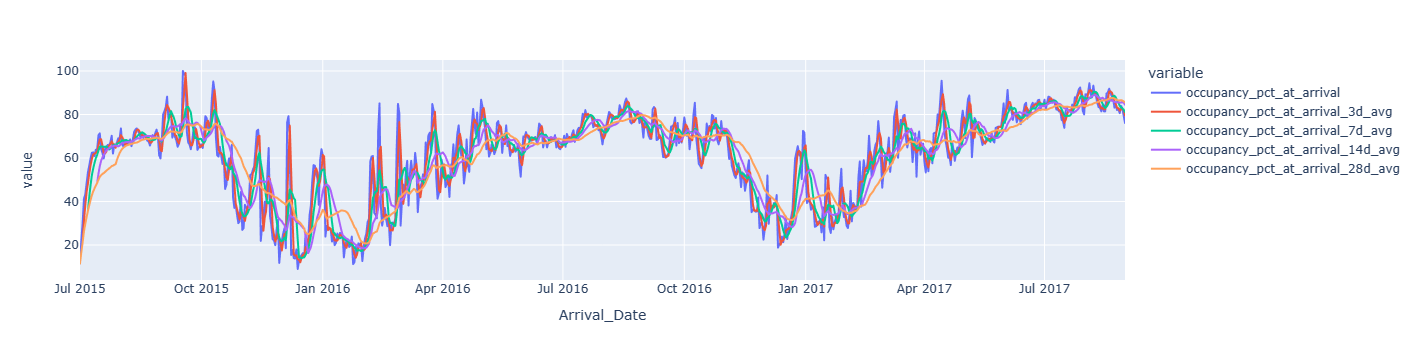

In [90]:
px.line(df_data_rollavg)